#### Disclaimer: Some portions of this code and content generated were assisted by generative AI (e.g., ChatGPT). We checked the generated content and corrected it, if applicable.

### Google colab use

Only run the cell below if you are on google colab. This will install opyrability on the google colab session to perform the uncertainty mapping. The kernel will be restarted and you might get a message "Your session crashed for an unknown reason.". You can safely disregard it and continue running the other cells.

In [ ]:
!pip install -q condacolab
!pip install ipympl
import condacolab
condacolab.install()
!conda install -c codes-group -c conda-forge opyrability

### Imports

In [1]:
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib ipympl

# CSTR Example Revisted - Bimodal uncertainty region

The CSTR model kinetics and model equations are revisited below:

$A \longrightarrow B$, \
with $-rA = k_1 C_a$, and \
$A \longrightarrow C$ with \
$-rA = k_2 C_a^2$. \
Let the volume of the CSTR be 1, \
with a volumetric flow of $1 L / min$ of $1 M C_a$.
Let $k_1 = 3$, and $k_2 = 2$.

$$ 0 = Fa0 - Fa + rA * V $$
$$= Fa_0 - v_0 * Ca - (k_1 Ca + k_2 * Ca^{2}) * V$$

Some rearrangement there leads to:

$$k_2 Ca^{2} + (v_0 / V + k_1) Ca - Fa_0 / V = 0$$
    
which we can solve with the quadratic equation to get $C_a$.

Then a mole balance on B yields:

$$0 = -Fb + k_1 Ca V$$
$$Cb = k_1 Ca V / v_0$$
    
So we can readily compute Ca and Cb. We do that here. This gives us an initial solution.

# A path describing the uncertainty


For this specific case, we will assume that both $k_1$ and $k_2$ uncertainties are represented by a bimodal probability distribution, in order to show that the proposed approach is able to also map the corresponding Image correctly. For a reactive system, reasons for bi-modality or even multimodality would be:
 
 1. The presence of alternative reaction pathways, 
 2. Distinct thermodynamic states (e.g., low-energy vs. high energy states), 
 3. Experimental variability, that is, different experiments that might yield slightly different distributions.


Instead of assuming a single Gaussian distribution, we use a **bimodal Gaussian Mixture Model (GMM)** to represent two dominant kinetic behaviors.


A **Gaussian Mixture Model (GMM)** is defined as:

$$
    p(k_1, k_2) = \sum_{i=1}^{2} w_i \mathcal{N}(k_1, k_2 \mid \mu_i, \Sigma_i)
$$

where:
- $ w_i $ are the **mixing weights** (probabilities of each mode, summing to 1).
- $ \mathcal{N}(k_1, k_2 \mid \mu_i, \Sigma_i) $ represents each **Gaussian component** with mean $ \mu_i $ and covariance matrix $ \Sigma_i $.
- $ p(k_1, k_2) $ is the **overall probability density function**.

We define the two modes below:

In [3]:
# Define bimodal distribution for k1 and k2
mean1 = [3.2, 1.8]  # First mode
cov1 = [[0.02, 0.005], [0.005, 0.5]]

mean2 = [2.8, 2.2]  # Second mode
cov2 = [[0.02, -0.005], [-0.005, 0.5]]

weights = [0.65, 0.35]  # Equal probability for each mode

gauss1 = multivariate_normal(mean1, cov1)
gauss2 = multivariate_normal(mean2, cov2)

def mixture_pdf(k1, k2):
    """Computes the probability density for the bimodal distribution."""
    pos = np.dstack((k1, k2))
    return weights[0] * gauss1.pdf(pos) + weights[1] * gauss2.pdf(pos)

# Compute Probability Density Grid

We evaluate the **bimodal probability density function (PDF)** over a **grid of kinetic constants**.


In [4]:
k1_vals = np.linspace(2, 4, 300)
k2_vals = np.linspace(0.1, 4, 300)
k1_grid, k2_grid = np.meshgrid(k1_vals, k2_vals)
density_values = mixture_pdf(k1_grid, k2_grid)

# Find the Confidence Contour Threshold

We find the density threshold that encloses **95% of the confidence region** of this bi-modal distribution.

To find the **95% confidence region**, we identify the density level \( t \) such that:

$$
 \int_{p(k_1, k_2) > t} p(k_1, k_2) dk_1 dk_2 = 0.95
$$

This means **95% of the probability distribution** is contained inside the contour where $ p(k_1, k_2) = t $.

In [5]:
# Find confidence level threshold (95%)
densities_sorted = np.sort(density_values.ravel())
cumulative_densities = np.cumsum(densities_sorted) / np.sum(densities_sorted)
confidence_level = 0.95
density_threshold = densities_sorted[np.argmax(cumulative_densities >= (1 - confidence_level))]

## **4. Compute the Parametric Confidence Contour**

To generate a **closed parametric contour**, we use a radial search strategy:

1. **Start at an angle** $ \theta $ in polar coordinates.
2. **Increase radius $ r $** until the density matches the threshold $ t $.
3. **Store points** in Cartesian coordinates.

The parametric equations of the contour are:

$$
 k_1(\theta) = k_{1, center} + r(\theta) \cos(\theta)
$$
$$
 k_2(\theta) = k_{2, center} + r(\theta) \sin(\theta)
$$

In [6]:
def find_radius(theta, center, step=0.001):
    """Finds the radial distance r where the density reaches the confidence threshold."""
    r = 0.001  # Initial small radius
    while mixture_pdf(center[0] + r * np.cos(theta), center[1] + r * np.sin(theta)) > density_threshold:
        r += step
    return r

# Generate parametric confidence contour
num_points = 400
theta_vals = np.linspace(0, 2 * np.pi, num_points)
contour_k1, contour_k2 = [], []

for theta in theta_vals:
    r = find_radius(theta, center=[3, 2])  # Center of bimodal region
    contour_k1.append(3 + r * np.cos(theta))
    contour_k2.append(2 + r * np.sin(theta))

contour_k1 = np.array(contour_k1)
contour_k2 = np.array(contour_k2)

##  Visualizing the Parametric Contour

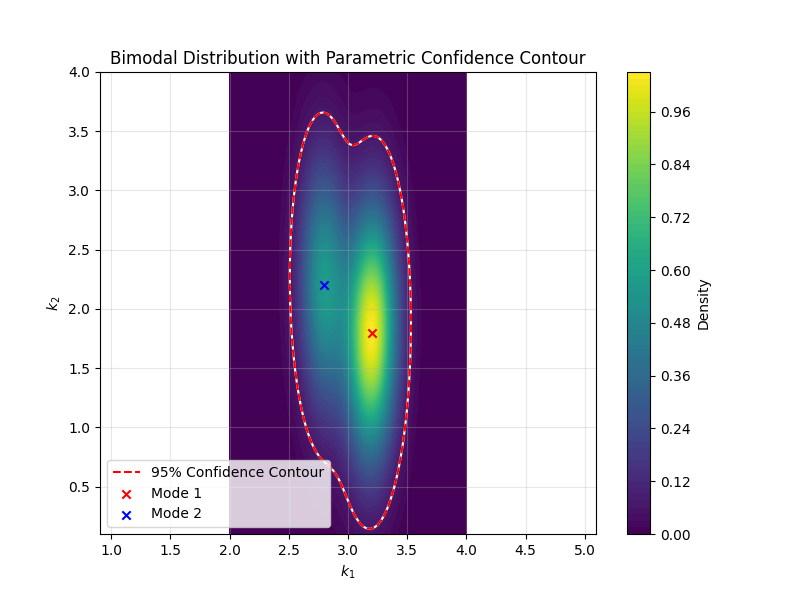

In [7]:
plt.figure(figsize=(8, 6))
plt.contourf(k1_grid, k2_grid, density_values, levels=100, cmap='viridis')
plt.colorbar(label='Density')
plt.contour(k1_grid, k2_grid, density_values, levels=[density_threshold], colors='white', linewidths=1.5)
plt.plot(contour_k1, contour_k2, 'r--', label='95% Confidence Contour')
plt.scatter(mean1[0], mean1[1], color='red', marker='x', label='Mode 1')
plt.scatter(mean2[0], mean2[1], color='blue', marker='x', label='Mode 2')
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')
plt.title('Bimodal Distribution with Parametric Confidence Contour')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

##  3D Projection of the Bimodal Probability Distribution

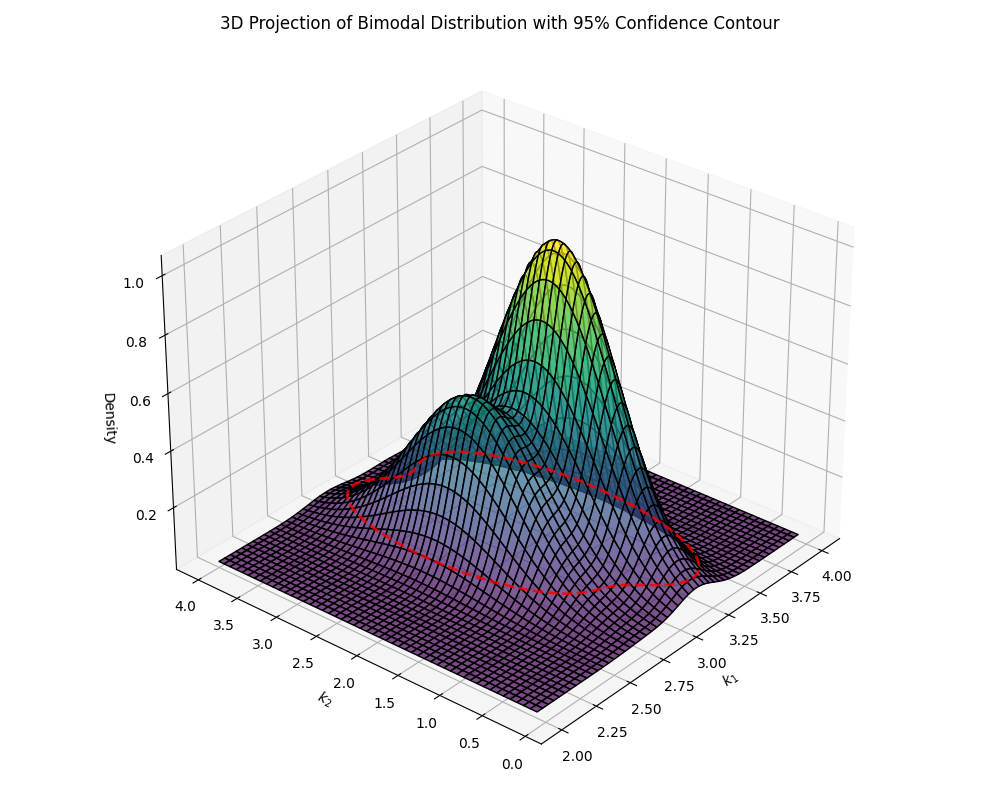

In [8]:
fig = plt.figure(figsize=(10, 8))
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(k1_grid, k2_grid, density_values, cmap='viridis', edgecolor='k', alpha=0.7, zorder=1)
ax3d.set_xlabel('$k_1$')
ax3d.set_ylabel('$k_2$')
ax3d.set_zlabel('Density')
ax3d.set_title('3D Projection of Bimodal Distribution with 95% Confidence Contour')

# Overlay the 95% confidence contour on the 3D plot
ax3d.plot(contour_k1, contour_k2, np.full_like(contour_k1, density_threshold), 'w-', linewidth=3, zorder=2)
ax3d.plot(contour_k1, contour_k2, np.full_like(contour_k1, density_threshold) + 0.02, 'r--', linewidth=2, zorder=3, alpha=0.8)

# Adjust view angle to improve visibility
ax3d.view_init(elev=30, azim=220)
plt.tight_layout()
plt.show()

## Uncertainty mapping using differentiable programing through opyrability


Ca_0 = 0.20258612341612325, Cb_0=0.7153316017823313


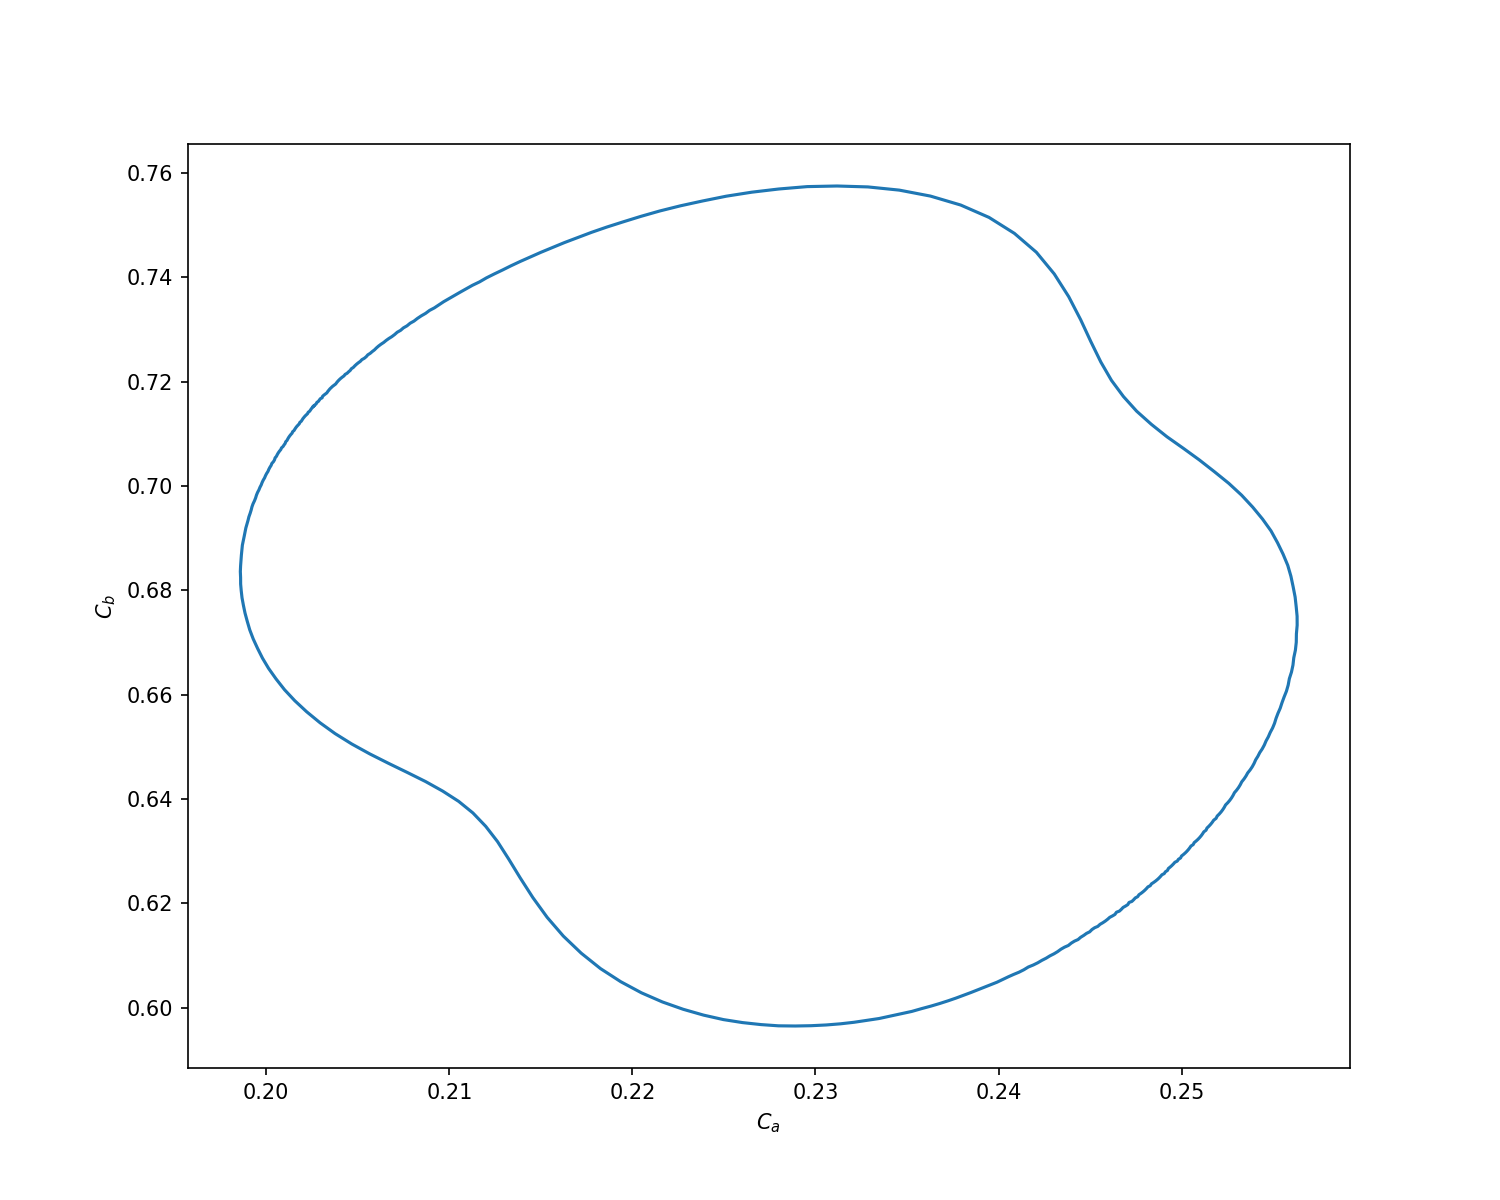

In [20]:
v0 = V = Ca0 = 1
Fa0 = Ca0 * v0

a, b, c = contour_k2, (v0 / V + contour_k1), -Fa0 / V

aCa = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
aCb = contour_k1 * aCa * V / v0
fig = plt.figure(figsize=(10, 8))
plt.plot(aCa, aCb)
plt.xlabel('$C_a$')
plt.ylabel('$C_b$')

print(f'Ca_0 = {aCa[0]}, Cb_0={aCb[0]}')

In [10]:
from opyrability import implicit_map

Defining a starting point from the analytical solution.

In [11]:
AIS_points = np.array([contour_k1,contour_k2]).T

output_init = np.array([aCa[0], aCb[0]])

Forward Mapping Selected.
The given domain is recognized as an Available Input Set (AIS).
The result of this mapping is an Achievable Output Set(AOS)
Selected Euler


100%|██████████| 400/400 [00:05<00:00, 67.18it/s]


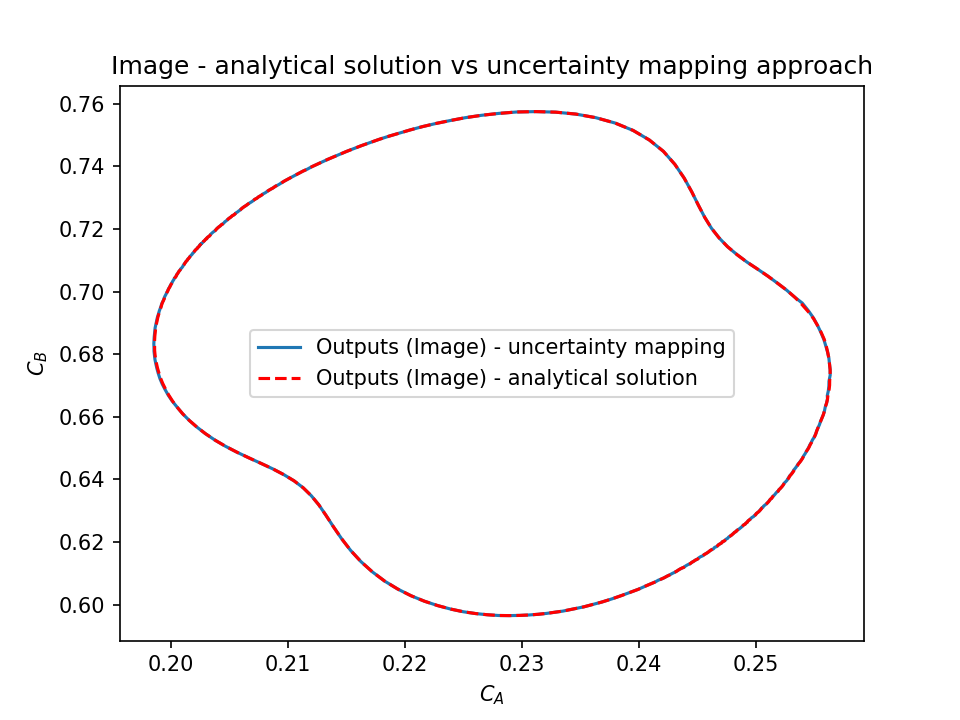

In [12]:
def implicit_function(k, C):
    k1 = k[0]
    k2 = k[1]
    Ca = C[0]
    Cb = C[1]

    z1 = Fa0 - Ca * v0 - (k1 * Ca + k2 * Ca**2) * V
    z2 = -Cb * v0 + k1 * Ca * V

    return np.array([z1, z2])



AIS, AOS, AIS_poly, AOS_poly = implicit_map(implicit_function,
                                    output_init,
                                    continuation='Explicit Euler',
                                    domain_points=AIS_points,
                                    direction = 'forward',
                                    tol_cor= 1e-7)

AOS_points = AOS.reshape(-1,2)
AIS_opyrability = AIS.reshape(-1,2)
plt.plot(AIS_opyrability[:,0], AIS_opyrability[:,1], label='AIS points, opyrability')
plt.plot(AIS_points[:,0], AIS_points[:,1], label='Inputs (Domain) points, enumeration')
plt.legend()
from matplotlib import pyplot
pyplot.figure()
plt.plot(AOS_points[1:,0], AOS_points[1:,1], label='Outputs (Image) - uncertainty mapping')
plt.plot(aCa, aCb, 'r--', label='Outputs (Image) - analytical solution')
plt.title('Image - analytical solution vs uncertainty mapping approach')
plt.xlabel('$C_A$')
plt.ylabel('$C_B$')
plt.legend()


## Comparing with MC simulations

##  Monte Carlo Sampling for the Bimodal Distribution

Now, we perform **Monte Carlo sampling** based on the **bimodal distribution** instead of a single Gaussian ellipse. This allows us to simulate kinetic parameters following the true probability distribution.

### **Methodology:**
1. **Randomly select a mode** (using the mixture weights $ w_1, w_2 $).
2. **Sample from the corresponding Gaussian distribution**.
3. **Repeat for \( N \) simulations** to generate a representative dataset.

In [13]:
# Set JAX random key
from jax import random
key = random.PRNGKey(0)
num_simulations = 100000

# Split the key for reproducibility
key, subkey = random.split(key)

# Generate random mixture selection (0 = Mode 1, 1 = Mode 2)
mode_selection = random.choice(subkey, np.array([0, 1]), shape=(num_simulations,), p=np.array(weights))

# Generate separate samples for each mode
key1, key2 = random.split(key)
samples_mode1 = random.multivariate_normal(key1, np.array(mean1), np.array(cov1), shape=(num_simulations,))
samples_mode2 = random.multivariate_normal(key2, np.array(mean2), np.array(cov2), shape=(num_simulations,))

# Combine samples based on selected modes
samples = np.where(mode_selection[:, None] == 0, samples_mode1, samples_mode2)

## Visualizing Monte Carlo Sampling

We compare **Monte Carlo samples** to the **95% parametric confidence contour**.

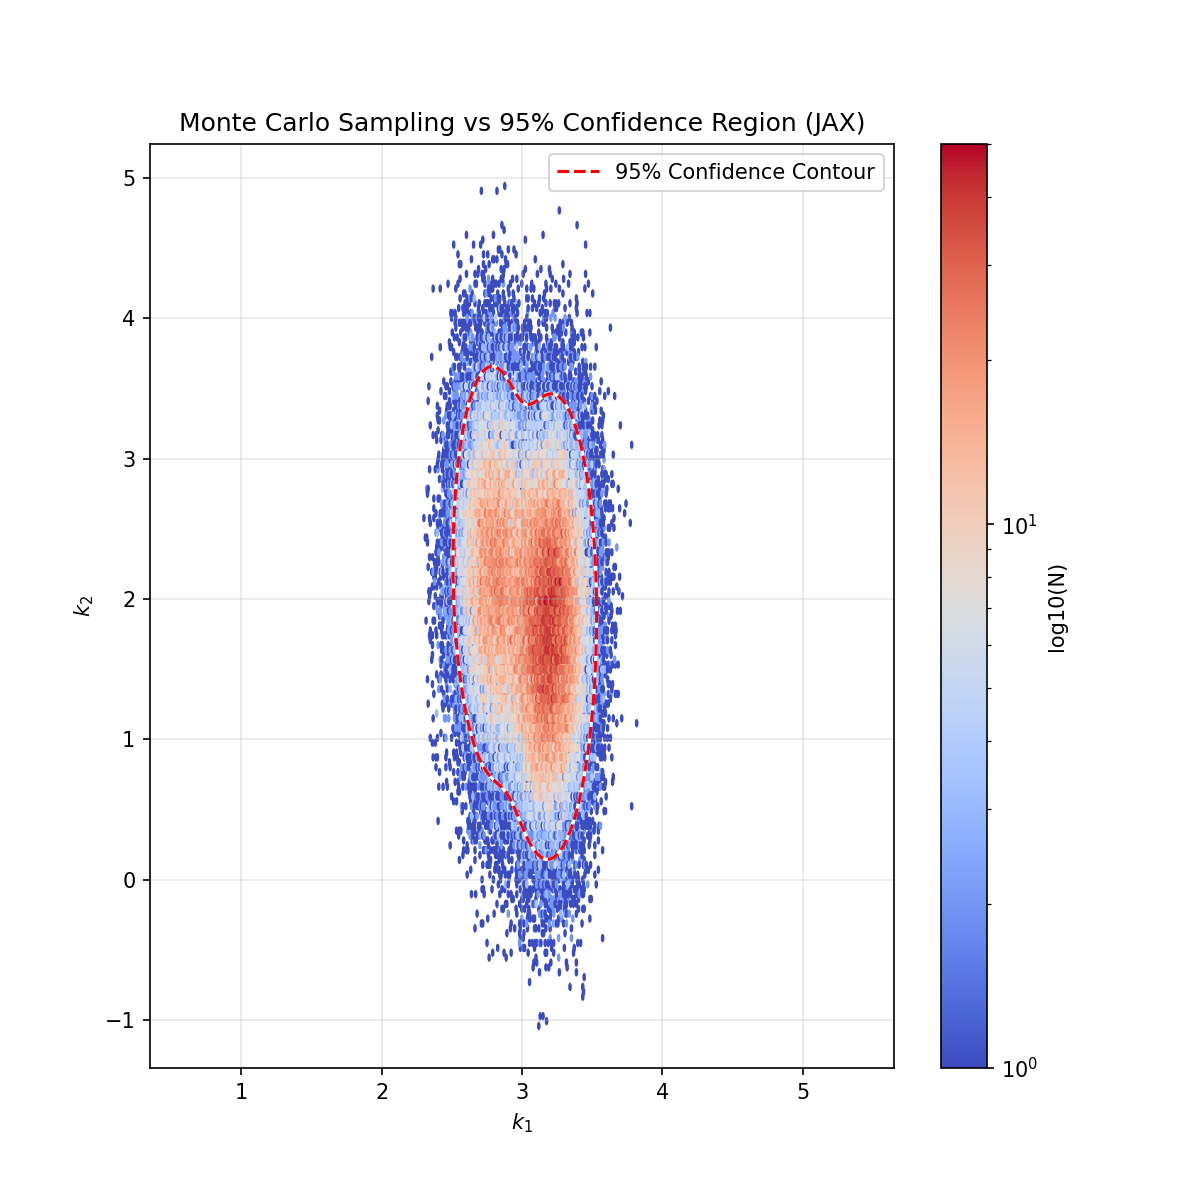

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
# contour = ax.contourf(k1_grid, k2_grid, density_values, levels=100, cmap='viridis')
# fig.colorbar(contour, ax=ax, label='Density')  # Fix: Attach colorbar to the figure, not the axes
ax.contour(k1_grid, k2_grid, density_values, levels=[density_threshold], colors='white', linewidths=1.5)
ax.plot(contour_k1, contour_k2, 'r--', label='95% Confidence Contour')

# Monte Carlo Sampling visualization
hb = ax.hexbin(samples[:, 0], samples[:, 1], gridsize=150, cmap='coolwarm', bins='log')
fig.colorbar(hb, ax=ax, label='log10(N)')

ax.set_xlabel('$k_1$')
ax.set_ylabel('$k_2$')
ax.set_title('Monte Carlo Sampling vs 95% Confidence Region (JAX)')
ax.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
k1_samples = samples[:, 0]
k2_samples = samples[:, 1]


# Calculating Ca and Cb for each Monte Carlo simulation
Ca_values = []
Cb_values = []
for i in range(num_simulations):
    k1 = k1_samples[i]
    k2 = k2_samples[i]

    a, b, c = k2, (v0 / V + k1), -Fa0 / V
    aCa = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    aCb = k1 * aCa * V / v0

    Ca_values.append(aCa)
    Cb_values.append(aCb)



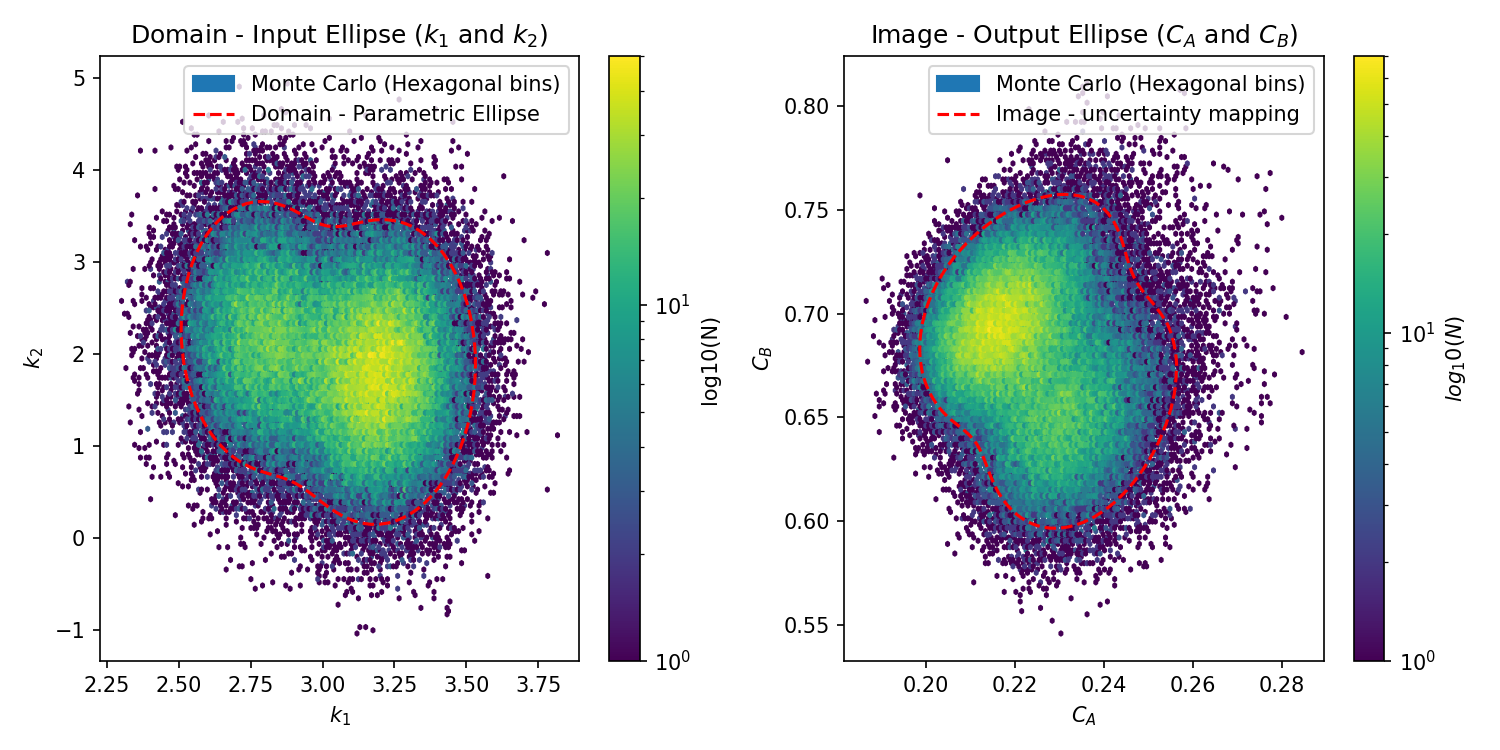

In [16]:
# Plotting the input ellipse for k1 and k2
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(10,5))
hb = ax1.hexbin(k1_samples, k2_samples, gridsize=150, cmap='viridis', bins='log', label='Monte Carlo (Hexagonal bins)')
fig.colorbar(hb, ax=ax1, label='log10(N)')
ax1.plot(AIS_points[:,0], AIS_points[:,1], 'r--', label='Domain - Parametric Ellipse')
ax1.set_title('Domain - Input Ellipse ($k_1$ and $k_2$)')
ax1.set_xlabel('$k_1$')
ax1.set_ylabel('$k_2$')
ax1.legend()

# Plotting the output ellipse for Ca and Cb
hb = ax2.hexbin(Ca_values, Cb_values, gridsize=150, cmap='viridis', bins='log', label='Monte Carlo (Hexagonal bins)')
fig.colorbar(hb, ax=ax2, label='$log_10(N)$')
ax2.plot(AOS_points[1:,0], AOS_points[1:,1],'r--', label='Image - uncertainty mapping')
ax2.set_title('Image - Output Ellipse ($C_A$ and $C_B$)')
ax2.set_xlabel('$C_A$')
ax2.set_ylabel('$C_B$')
ax2.legend()
plt.tight_layout()

## Counting points within the ellipse

In [17]:
points =  np.array([Ca_values, Cb_values]).T

points.shape

(100000, 2)

In [18]:

import matplotlib.path as mpath

path = mpath.Path(AOS_points)

inside_points = path.contains_points(points)

points_in =  np.sum(inside_points)
points_out = len(points) - points_in

print('there are', points_in, 'points within the ellipse')
print('there are', points_out, 'points outside the ellipse')

there are 94282 points within the ellipse
there are 5718 points outside the ellipse


In [19]:
print(points_in/num_simulations * 100, '%')

94.282 %


$\approx 95\%$ of the points within the elipse.